# Spatial Interpolation of WQ data

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio contextily
`

**Note: installation of geopandas may take a few hours**

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c)

In [1]:
import time
import math  
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
arcpy.env.overwriteOutput = True

# 1. Load Discrete Data and Continuous Data

In [2]:
# path = "E:/Projects/SEACAR_WQ_Pilot/"
# gis_path = path+'GIS_data/'

path = "D:/Water_Quailty/"
gis_path = path+'Test02201/'

In [4]:
dfDis_orig = pd.read_csv(path + r"OEAT_Discrete-2023-Jan-23.csv")
dfCon1_orig = pd.read_csv(path + r"OEAT_Continuous_1-2023-Jan-23.csv")
dfCon2_orig = pd.read_csv(path + r"OEAT_Continuous_2-2023-Jan-23.csv")

C:\arcpyenv\arcpygeo\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (6,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2 Preprocess Data
Preset function parameters

In [19]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


Area = 'Big Bend Seagrasses Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ls = "DO"
SpatialRef = '3086'
dry_start,dry_end = '11/01/2016','04/30/2017'
wet_start,wet_end = '05/01/2017','10/31/2017'

Function to preprocess dataframes

In [6]:
def preprocessDis(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 10)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['Year'] < 1995)].index, inplace=True)
    
    return df

def preprocessCon(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    # ------- Select data during daytime ------
    df["Hour"]     = df.apply(lambda x:x["timestamp"].strftime("%H"), axis=1)
    df["Hour"]     = df["Hour"].astype(int)
    df             = df[(df["Hour"]>=8) & (df["Hour"]<=18)]
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 10)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['Year'] < 1995)].index, inplace=True)
    
    return df

Preprocess dataframes

In [7]:
dfCon1 = preprocessCon(dfCon1_orig, col_ls, para_ls)
dfCon2 = preprocessCon(dfCon2_orig, col_ls, para_ls)
dfDis  = preprocessDis(dfDis_orig, col_ls, para_ls)
dfCon  = pd.concat([dfCon1,dfCon2],ignore_index=True)

In [15]:
dfDis.to_csv(gis_path+"discrete_0214.csv")
dfCon.to_csv(gis_path+"continuous_0214.csv")

In [132]:
# In the future, we can open "discrete_0214.csv" and "continuous_0214.csv" to save time

In [5]:
dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

C:\arcpyenv\arcpygeo\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2. Combine Dis Data and Con Data

Combine dataframes

In [7]:
def combine_dis_con_dry(df_dis,df_con, year):
    
    year_start = str(int(year)-1)
    year_end   = str(year)
    dry_start,dry_end = ('11/01/'+year_start),('04/30/'+year_end)
    
    df_dis = df_dis[(df_dis['timestamp'] > dry_start)&(df_dis['timestamp'] < dry_end)]
    df_dis_mean = df_dis.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

    df_con = df_con[(df_con['timestamp'] > dry_start)&(df_con['timestamp'] < dry_end)]
    df_con_mean = df_con.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
   
    # Concatenate dry and wet dataframes
    df_mean = pd.concat([df_dis_mean,df_con_mean],ignore_index=True)
    gdf = gpd.GeoDataFrame(df_mean, geometry = gpd.points_from_xy(df_mean.Longitude_DD, df_mean.Latitude_DD), crs="EPSG:4326")
    
    return df_mean, gdf

def combine_dis_con_wet(df_dis,df_con, year):
    
    year_start = str(int(year)-1)
    year_end   = str(year)
    wet_start,wet_end = ('05/01/'+year_end),('10/31/'+year_end)

    df_dis = df_dis[(df_dis['timestamp'] > wet_start)&(df_dis['timestamp'] < wet_end)]
    df_dis_mean = df_dis.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

    df_con = df_con[(df_con['timestamp'] > wet_start)&(df_con['timestamp'] < wet_end)]
    df_con_mean = df_con.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
   
    # Concatenate dry and wet dataframes
    df_mean = pd.concat([df_dis_mean,df_con_mean],ignore_index=True)
    gdf = gpd.GeoDataFrame(df_mean, geometry = gpd.points_from_xy(df_mean.Longitude_DD, df_mean.Latitude_DD), crs="EPSG:4326")
    
    return df_mean, gdf

In [21]:
year = "2017"

dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Area = 'Big Bend Seagrasses Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


## Read Managed Areas

In [22]:
MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Big Bend Seagrasses'].to_crs(int(SpatialRef))
CH.to_file(gis_path+ 'ch.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

## Load Data

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [5]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+"ch.shp")

<AxesSubplot:>

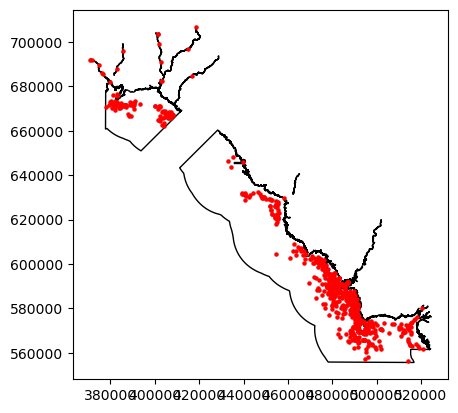

In [6]:
fig, ax = plt.subplots()
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

In [7]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

In [8]:
def interpolation_method(year,method):
    select_method = str(method)
    if   select_method == "idw":
        print("This is Inverse Distance Weighting interpolation method")
        with arcpy.EnvManager(extent=extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
                 arcpy.ga.IDW(in_features = gis_path+"Dry"+year+Para_ab+'.shp', 
                 z_field = "ResultValu", 
#                This layer is not generated  
                 out_ga_layer = gis_path +Para_ab+ "dryIDW.lyrx",
                 out_raster   = gis_path +Para_ab+ "dryIDW.tif"
                )

        with arcpy.EnvManager(extent=extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
                 arcpy.ga.IDW(in_features = gis_path+"Wet"+year+Para_ab+'.shp', 
                 z_field = "ResultValu", 
#                This layer is not generated  
                 out_ga_layer = gis_path +Para_ab+ "wetIDW.lyrx",
                 out_raster   = gis_path +Para_ab+ "wetIDW.tif"
                )
                
        fig, axes = plt.subplots(1,2, figsize=(18, 8))

        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryIDW.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
#           Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)

            gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
            extentShp.plot(ax = axes[1], color='none', edgecolor='black')
            cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetIDW.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
#           Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)       
                
    elif select_method == "ok":
        print("This is Ordinary Kriging interpolation method")
#       Calculate dry season
        search_radius = 20000
        with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
            out_surface_raster = arcpy.sa.Kriging(in_point_features = gis_path+"Dry"+year+Para_ab+'.shp',
                                          z_field = "ResultValu",
                                          kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))                           
#                                          "Spherical 0.000486 # # #",
#                                          0.000764192085967863,
#                                          "VARIABLE 12",
        out_surface_raster.save(gis_path+Para_ab+"dryKriging.tif")
#       Calculate wet season
        with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
            out_surface_raster = arcpy.sa.Kriging(gis_path+"Wet"+year+Para_ab+'.shp',
                                          "ResultValu",
                                         kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))
#                                           "Spherical 0.000486 # # #",
#                                           0.000764192085967863,
#                                          "VARIABLE 12",
                                          
        out_surface_raster.save(gis_path+Para_ab+"wetKriging.tif")
        
#       Draw the map
        fig, axes = plt.subplots(1,2, figsize=(18, 8))
        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)
        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryKriging.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)
        gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[1], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetKriging.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)

    elif select_method == "ebk":
        print("This is Empirical Bayesian Kriging interpolation method")
        start_time = time.time()

        with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                              cellSize = 30, parallelProcessingFactor = "80%"):
            arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path+"Dry"+year+Para_ab+'.shp', 
                                      z_field = "ResultValu", 
                                    # This layer is not generated  
                                      out_ga_layer = gis_path+Para_ab+"EBK_Dry_Layer",
                                      out_raster   = gis_path+Para_ab+"dryEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
            arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path+"Wet"+year+Para_ab+'.shp', 
                                      z_field = "ResultValu", 
                                     # This layer is not generated  
                                      out_ga_layer = gis_path+Para_ab+"EBK_Wet_Layer",
                                      out_raster = gis_path+Para_ab+"wetEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
        print("--- Time lapse: %s seconds ---" % (time.time() - start_time))
        
        fig, axes = plt.subplots(1,2, figsize=(18, 8))

        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryEBK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
#           Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)


        gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[1], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetEBK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
#       Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)

    elif select_method == "rk":
        print("This is Regression Kriging interpolation method")
        ma_table = pd.read_csv(gis_path + "MA_table.csv")
        ra_fname = 'basy_{}.tif'.format(ma_table[ma_table['LONG_NAME']== Area]['MA_AreaID'].iloc[0].astype(str))
        fig, ax = plt.subplots(1, figsize=(18, 8))

        fig.suptitle("{} (covariate: {}).".format(Area, 'basymetry'),fontsize=20)

        gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = ax, color='none', edgecolor='black')
        cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
        with rasterio.open(gis_path + "covariates/basymetry/basy_18.tif", "r+") as covar:
            band = covar.read(1)
            #band = numpy.ma.masked_array(band, mask=(band < -1000))
            #band = numpy.ma.masked_array(band, mask=(band > 1000))
            band = np.ma.masked_where((band < -100) | (band > 100), band)
            retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
            ax.set_title('Basymetry')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=ax,shrink=0.8)
            
        start_time = time.time()

        with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                              cellSize = 30, parallelProcessingFactor = "80%"):
            out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path+"Dry"+year+Para_ab+'.shp', 
                                                                   dependent_field = "ResultValu", 
                                                                  out_ga_layer = gis_path +Para_ab+ "dryRK_GA",
                                                                    out_raster = gis_path +Para_ab+ "dryRK.tif",
                                                                  in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'),
                                                                   transformation_type = 'EMPIRICAL',
                                                                  search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5)) 

            out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path+"Wet"+year+Para_ab+'.shp', 
                                                                   dependent_field = "ResultValu",
                                                                  out_ga_layer = gis_path +Para_ab+ "wetRK_GA",
                                                                  out_raster = gis_path +Para_ab+ "wetRK.tif",
                                                                  in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'),
                                                                   transformation_type = 'EMPIRICAL',
                                                                  search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))

        print("--- Time lapse: %s seconds ---" % (time.time() - start_time))
        
        fig, axes = plt.subplots(1,2, figsize=(18, 8))

        fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

        gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[0], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "dryRK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
            axes[0].set_title('Dry Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[0],shrink=0.8)


        gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
        extentShp.plot(ax = axes[1], color='none', edgecolor='black')
        cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

        # Raster must added after basemap
        with rasterio.open(gis_path +Para_ab+ "wetRK.tif", "r+") as dryOK:
            band = dryOK.read(1)
            band = numpy.ma.masked_array(band, mask=(band < 0))
            retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
            axes[1].set_title('Wet Season')
            # Add legend
            im = retted.get_images()[1]
            fig.colorbar(im, ax=axes[1],shrink=0.8)


# Ordinary Kriging

Run Oridinary Kriging for dry season data

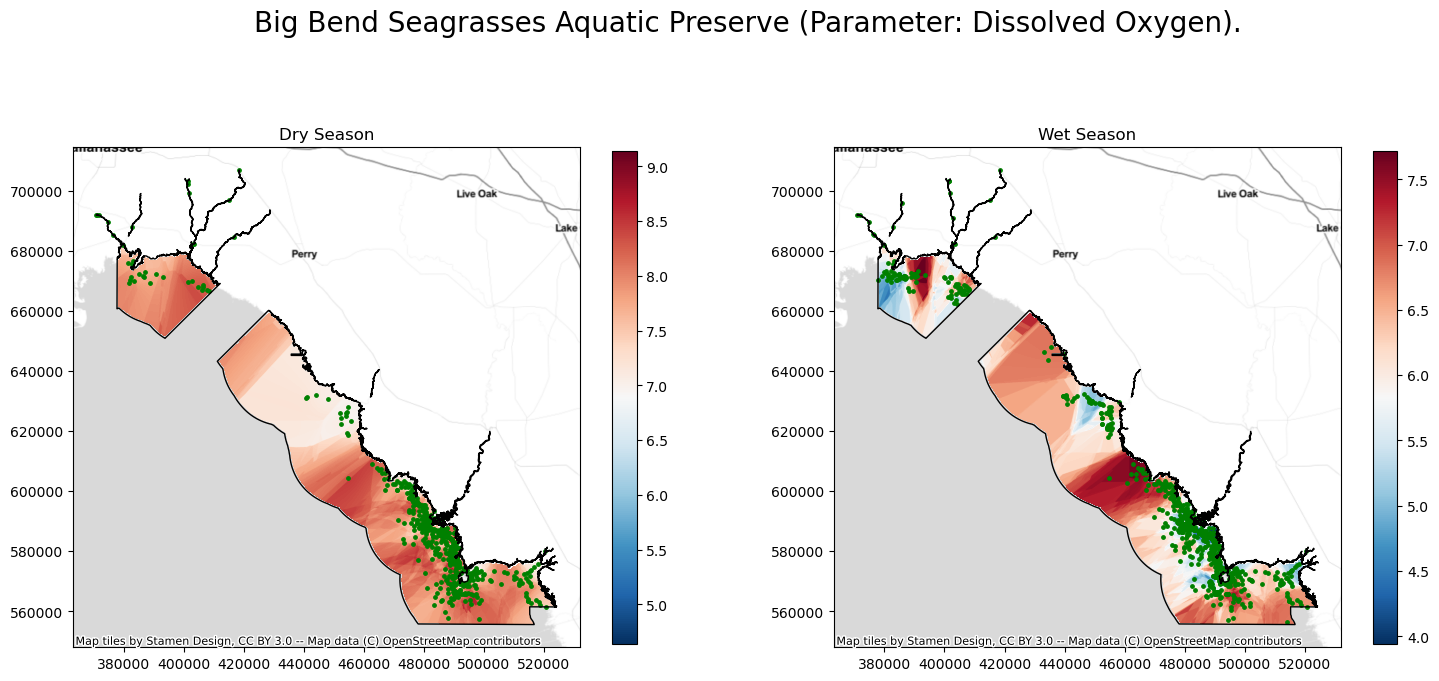

In [32]:
interpolation_method("2017","ok")

# Inverse Distance Weighting (IDW)

Run IDW for both wet and dry seasons

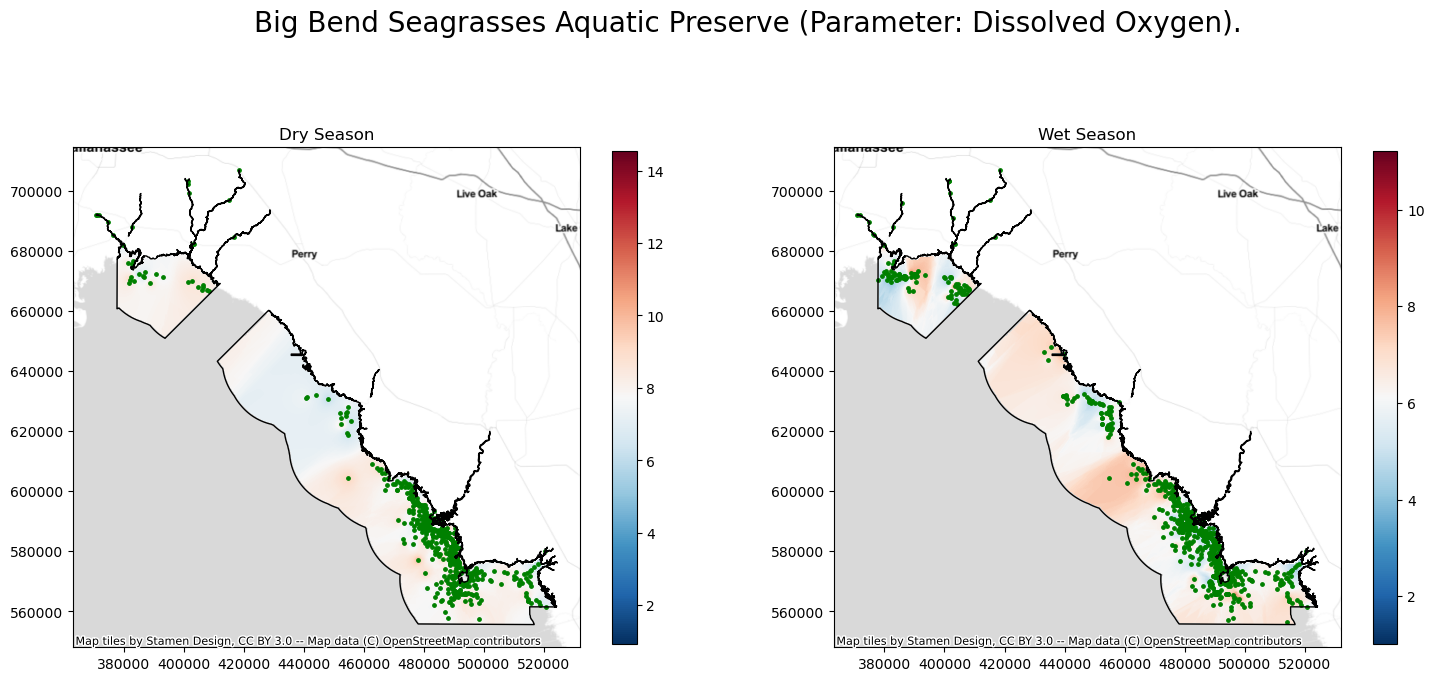

In [39]:
interpolation_method("2017","idw")

# Empirical Bayesian Kriging (EBK)

Run EBK for wet and dry seasons

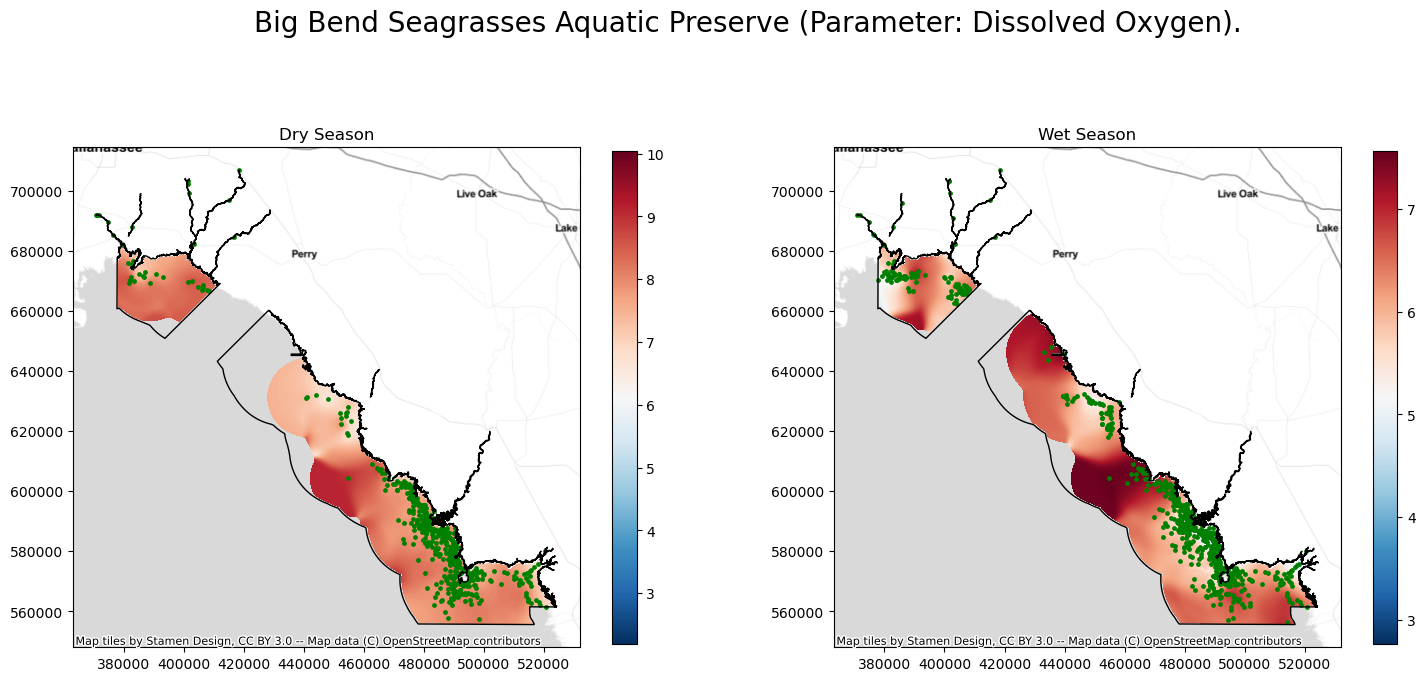

In [41]:
interpolation_method("2017","ebk")

# Regression Kriging (RK)

Run RK for wet and dry seasons

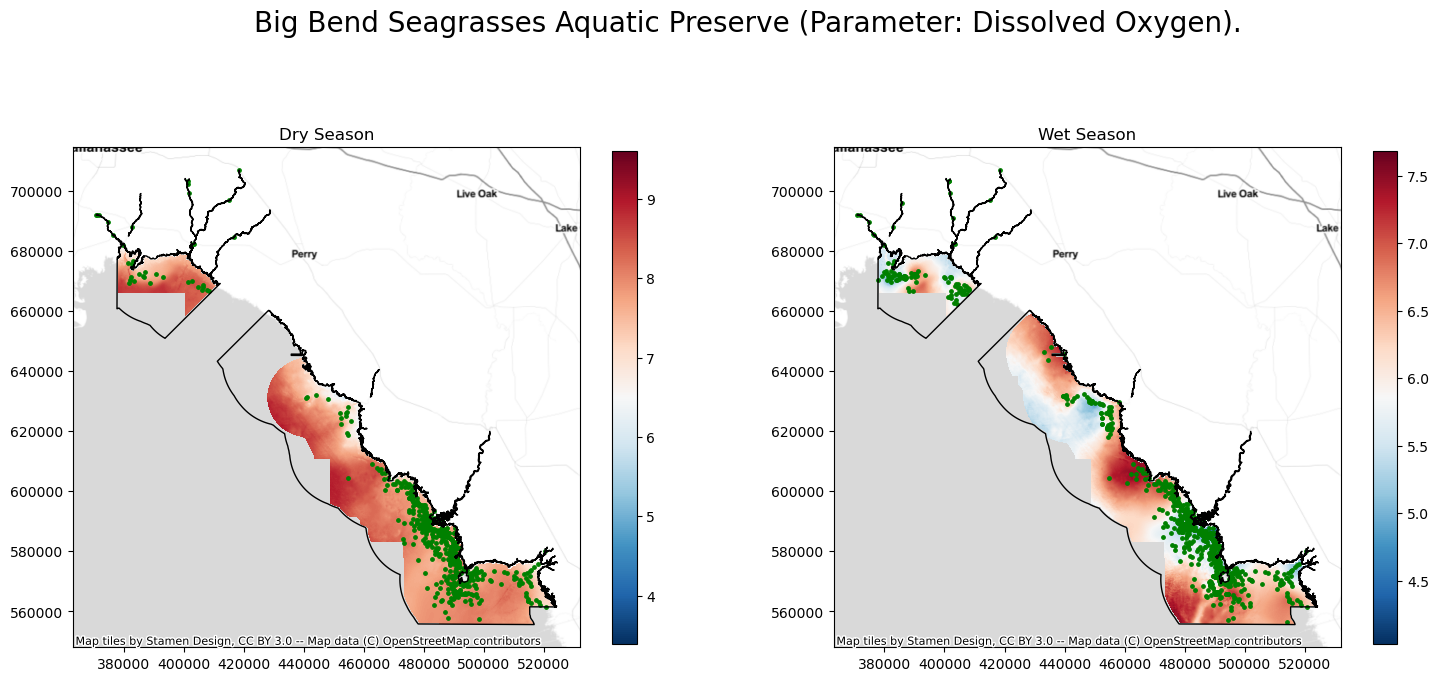

In [12]:
interpolation_method("2017","rk")

# Result Assessment

## Ordinary Kriging

In [13]:
gp = arcgisscripting.create()
gp.workspace = gis_path
gp.CheckOutExtension( 'GeoStats' )

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Dry"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'dryok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'dryok_GA', gis_path+Para_ab+'dryok_GA.lyrx',
                                 'ABSOLUTE')

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Wet"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'wetok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'wetok_GA', gis_path+Para_ab+'wetok_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02201\\DOwetok_GA.lyrx'>

In [14]:
inLayer = gis_path +Para_ab+ "dryok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])


inLayer = gis_path +Para_ab+ "wetok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])

In [15]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.0022,0.001,1.169


Interpolation assessment of Ordinary Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.0107,0.0042,1.4556


## Inverse Distance Weighting (IDW)

In [ ]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "dryIDW.lyrx", gis_path+Para_ab+'dryIDW_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "wetIDW.lyrx", gis_path+Para_ab+'wetIDW_GA.lyrx',
                                 'ABSOLUTE')

In [17]:
inLayer = gis_path+Para_ab + "dryIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


inLayer = gis_path+Para_ab + "wetIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [18]:
cvResult.meanStandardized

'NaN'

In [20]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,-0.0339,Nan,1.2145


Interpolation assessment of Inverse Distance Weighting in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,0.0366,Nan,1.6063


## Empirical Bayesian Kriging

In [ ]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Dry_Layer.lyrx", gis_path+Para_ab+'dryEBK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Wet_Layer.lyrx",a gis_path+Para_ab+'wetEBK_GA.lyrx',
                                 'ABSOLUTE')

In [ ]:
inLayer = gis_path+Para_ab + "dryEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


inLayer = gis_path+Para_ab + "wetEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [39]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,-0.0076,-0.0013,1.5951


Interpolation assessment of Empirical Bayesian Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,-0.0079,-0.0036,1.7716


## Regression Kriging

In [ ]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"dryRK_GA", gis_path+Para_ab+'dryRK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"wetRK_GA", gis_path+Para_ab+'wetRK_GA.lyrx',
                                 'ABSOLUTE')

In [41]:
inLayer = gis_path+Para_ab + "dryRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


inLayer = gis_path+Para_ab + "wetRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [42]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,0.0189,0.0129,1.599


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,0.0466,0.0254,1.7467


## Summary

In [43]:
sumStat1   = pd.concat([dryOKStat,dryIDWStat])
sumStat2   = pd.concat([dryEBKStat,dryRKStat])
sumStatDry = pd.concat([sumStat1,sumStat2])

In [44]:
print("Summary of interpolation assessment in dry season data")
sumStatDry

Summary of interpolation assessment in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.0559,0.0328,1.6362
Inverse Distance Weighting,-0.0690,Nan,1.7750
Empirical Bayesian Kriging,-0.0076,-0.0013,1.5951
Regression Kriging,0.0189,0.0129,1.5990


In [45]:
sumStat3   = pd.concat([wetOKStat,wetIDWStat])
sumStat4   = pd.concat([wetEBKStat,wetRKStat])
sumStatWet = pd.concat([sumStat3,sumStat4])

In [46]:
print("Summary of interpolation assessment in wet season data")
sumStatWet

Summary of interpolation assessment in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.0121,0.0083,1.8292
Inverse Distance Weighting,-0.0490,Nan,1.9753
Empirical Bayesian Kriging,-0.0079,-0.0036,1.7716
Regression Kriging,0.0466,0.0254,1.7467


# For Total Nitrogen and Salinity